# Image Similarity Search with Vector Database

Use CassIO and Astra DB / Apache Cassandra® for similarity searches between **image samples**, powered by image embeddings and Vector Search.

## Colab-specific setup

Make sure you have a Database and get ready to upload the Secure Connect Bundle and supply the Token string
(see [Pre-requisites](https://cassio.org/start_here/#vector-database) on cassio.org for details. Remember you need a **custom Token** with role [Database Administrator](https://awesome-astra.github.io/docs/pages/astra/create-token/)).

_Note: this notebook is part of the CassIO documentation. Visit [this page on cassIO.org](https://cassio.org/frameworks/direct_cassio/image_similarity_vectors/)._


### GPU Runtime recommended

The following demo runs best on a runtime of type **GPU**.
Please open the _Runtime_ / _Change Runtime Type_ menu and make sure you see "GPU" under _Hardware Acceleration_.
(it is suggested to do so right now, as a later switch would reset the kernel and lose all progress.)



In [ ]:
# install required dependencies
! pip install \
    "cassio==0.0.7" \
    "datasets==2.13.1" \
    "gradio==3.36.1" \
    "jupyter>=1.0.0" \
    "numpy==1.24.4" \
    "panns_inference==0.1.1" \
    "python-dotenv==1.0.0" \
    "scipy==1.11.1" \
    "torch==2.0.1" \
    "torchvision==0.15.2"

You will likely be asked to "Restart the Runtime" at this time, as some dependencies
have been upgraded. **Please do restart the runtime now** for a smoother execution from this point onward.

In [ ]:
# Input your database keyspace name:
ASTRA_DB_KEYSPACE = input('Your Astra DB Keyspace name (e.g. cassio_tutorials): ')

In [ ]:
# Input your Astra DB token string, the one starting with "AstraCS:..."
from getpass import getpass
ASTRA_DB_TOKEN_BASED_PASSWORD = getpass('Your Astra DB Token ("AstraCS:..."): ')

### Astra DB Secure Connect Bundle

Please upload the Secure Connect Bundle zipfile to connect to your Astra DB instance.

The Secure Connect Bundle is needed to establish a secure connection to the database.
Click [here](https://awesome-astra.github.io/docs/pages/astra/download-scb/#c-procedure) for instructions on how to download it from Astra DB.

In [ ]:
# Upload your Secure Connect Bundle zipfile:
import os
from google.colab import files


print('Please upload your Secure Connect Bundle')
uploaded = files.upload()
if uploaded:
    astraBundleFileTitle = list(uploaded.keys())[0]
    ASTRA_DB_SECURE_BUNDLE_PATH = os.path.join(os.getcwd(), astraBundleFileTitle)
else:
    raise ValueError(
        'Cannot proceed without Secure Connect Bundle. Please re-run the cell.'
    )

In [ ]:
# colab-specific override of helper functions
from cassandra.cluster import (
    Cluster,
)
from cassandra.auth import PlainTextAuthProvider

# The "username" is the literal string 'token' for this connection mode:
ASTRA_DB_TOKEN_BASED_USERNAME = 'token'


def getCQLSession(mode='astra_db'):
    if mode == 'astra_db':
        cluster = Cluster(
            cloud={
                "secure_connect_bundle": ASTRA_DB_SECURE_BUNDLE_PATH,
            },
            auth_provider=PlainTextAuthProvider(
                ASTRA_DB_TOKEN_BASED_USERNAME,
                ASTRA_DB_TOKEN_BASED_PASSWORD,
            ),
        )
        astraSession = cluster.connect()
        return astraSession
    else:
        raise ValueError('Unsupported CQL Session mode')

def getCQLKeyspace(mode='astra_db'):
    if mode == 'astra_db':
        return ASTRA_DB_KEYSPACE
    else:
        raise ValueError('Unsupported CQL Session mode')

### Colab preamble completed

The following cells constitute the demo notebook proper.

# Image Similarity Search with Vector Database

Use CassIO and Astra DB / Apache Cassandra® for similarity searches between **image samples**, powered by image embeddings and Vector Search.

_**NOTE:** this uses Cassandra's "Vector Similarity Search" capability.
Make sure you are connecting to a vector-enabled database for this demo._

In this notebook you will:

1. Download CIFAR10 dataset comprising of image samples from torchvision library.
2. Calculate image embedding vectors for them with SqueezeNet.
3. Store the embedding vectors on a table in your Cassandra / Astra DB instance, using the CassIO library for ease of operation.
4. Run one or more searches for images similar to a provided sample.
5. Start a simple web-app that exposes a **image search** feature.

### Import packages

The CassIO object needed for this demo is the `VectorTable`:

In [1]:
from cassio.vector import VectorTable

Other packages are needed for various tasks in this demo:

In [2]:
import os

from tqdm.auto import tqdm
import torch
import numpy as np
from IPython.display import display

# To load image dataset
import torchvision
import gradio
# To plot images
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
try:
    from google.colab import files
    IS_COLAB = True
except ModuleNotFoundError:
    IS_COLAB = False

### Connect to your DB

A database connection is needed to access Cassandra. The following assumes
that a _vector-search-capable Astra DB instance_ is available. Adjust as needed.

In [4]:
# creation of the DB connection
cqlMode = 'astra_db'
session = getCQLSession(mode=cqlMode)
keyspace = getCQLKeyspace(mode=cqlMode)


## Load the Data

In this demo, you will use image samples from the [Cifar10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), a labeled collection of 60000 32x32 colour images in 10 classes, with 6000 images per class.

 When preparing data for the pre-trained PyTorch models, it's essential to follow transformation (preprocess) steps for better results. The input images should have three channels and be in RGB format, with dimensions of at least 224 pixels in height and width (3 x H x W). Moreover, the pixel values undergo normalization using the mean values [0.485, 0.456, 0.406] and standard deviation values [0.229, 0.224, 0.225]. These mean and std values were calculated based on the ImageNet dataset. The dataset can be loaded from the torchvision library as follows:

In [5]:
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    ToTensor,
    Normalize
)
preprocess = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
DATA_DIRECTORY = 'data'

datasets = {
    'CIFAR10': torchvision.datasets.CIFAR10(DATA_DIRECTORY, transform=preprocess, download=True),
}

Files already downloaded and verified


## Display few images

Each image belongs to a "class label". Take a look at the class labels for the random images in the dataset:

These are labels with their respective names :

In [7]:
labels_dict = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

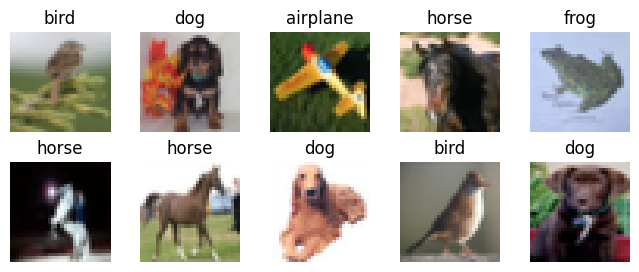

In [8]:
def show_random_images_from_full_dataset(dset, num_rows=2, num_cols=5):
    """Show random sample of images in PyTorch dataset."""

    ### get random sample of images and labels
    indices = np.random.randint(0, high=len(dset)+1, size=num_rows*num_cols)
    im_arrays = np.take(dset.data, indices, axis=0)
    labels = [dset.classes[dset.targets[index]] for index in indices]
    ### plot sample
    fig = plt.figure(figsize=(8, 8))
    grid = ImageGrid(
        fig,
        111,
        nrows_ncols=(num_rows, num_cols),
        axes_pad=0.3)
    for ax, im_array, label in zip(grid, im_arrays, labels):
        ax.imshow(im_array)
        ax.set_title(label)
        ax.axis("off")
show_random_images_from_full_dataset(datasets['CIFAR10'])

## Select only few images from each class


It generally takes around 1-2 mins to load 500 images per class. Loading 5000 images if GPU is avaliable , else loading 2000 images to reduce processing time.

In [9]:
GPU_AVAILABLE = torch.cuda.device_count() > 0

images_per_class=100 # You can modify the no of images per class
no_of_classes=10
selected_images = []  # List to store selected images
labels=[]
selected_img_array=[]

if GPU_AVAILABLE:
    print("\nGPU is available, hence loading 500 images per class")
    images_per_class=500

else:
    print("\nCPU is available, hence loading 200 images per class")
    images_per_class=200

# Iterate through each class and select 100 images
for class_label in range(no_of_classes):
    image_count = 0

    for i in range(len(datasets['CIFAR10'])):
        image, label = datasets['CIFAR10'][i]

        if label == class_label:
            selected_images.append(image)
            labels.append(label)
            selected_img_array.append(datasets['CIFAR10'].data[i])
            image_count += 1

        if image_count >= images_per_class:
            break

print("Total selected images:", len(selected_images))

/home/USER/.virtualenvs/cassio-direct-website-3.10/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



CPU is available , hence loading 200 images per class
Total selected images: 2000


## Loading a Pretrained SqueezeNet Computer Vision Model

To utilize a pre-trained model provided by PyTorch, you can load it and use its output as an embedding for image data. This pre-trained model generates a sequence of floats with 1000 dimensions per input image.






In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.squeezenet1_1(pretrained=True).to(device).eval()

if GPU_AVAILABLE:
    print("\nLoaded the image embedding model on the GPU.")
else:
    print(
        "\nLoaded the image embedding model on the CPU. Reduced defaults "
        "will be used. Please consider upgrading to a GPU-powered "
        "hardware for best experience."
    )

/home/USER/.virtualenvs/cassio-direct-website-3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/USER/.virtualenvs/cassio-direct-website-3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /home/USER/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████


Loaded the image embedding model on the CPU. Reduced defaults will be used. Please consider upgrading to a GPU-powered hardware for best experience.


## Create a DB table through CassIO

When an instance of `VectorTable` is created, CassIO takes care of the underlying database operations. An important parameter to supply is the embedding vector dimension (fixed, in this case, by the choice of the SqueezeNet model being used):

In [11]:
table_name = "image_table"
embedding_dimension = 1000

v_table = VectorTable(
    session=session,
    keyspace=keyspace,
    table=table_name,
    embedding_dimension=embedding_dimension,
    primary_key_type="TEXT",
)

## Preparing Vector Embeddings
This cell will encode the downloaded images and store the associated class of each image as metadata.

In [12]:
def get_vector_metadata(label_indices, class_list):
    """Return list of {'label': <class name>}."""
    return [{'label': class_list[index]} for index in label_indices]

# Creating Vector IDs
# Each vector ID will have a prefix corresponding to CIFAR10
def get_vector_ids(batch_number, batch_size, prefix):
    """Return vector ids."""
    start_index = batch_number
    end_index = start_index + batch_size
    ids = np.arange(start_index, end_index)

    # create id based on prefix
    # eg. if id == 5, prefix == 'CIFAR10', then create 'CIFAR10.5' as vector id.
    ids_with_prefix = [f'{prefix}.{str(x)}' for x in ids]
    return ids_with_prefix


def get_vectors_from_batch(data_processed, label_indices,batch_number, dataset):
    """Return list of tuples like (vector_id, vector_values, vector_metadata)."""
    num_records = len(data_processed)
    prefix = dataset.__class__.__name__
    with torch.no_grad():
        # generate image embeddings with PyTorch model
        vector_values = model(data_processed).tolist()
    # return respective IDs/metadata for each image embedding
    vector_metadata = get_vector_metadata(label_indices, dataset.classes)
    vector_ids = get_vector_ids(batch_number, num_records, prefix)
    return list(zip(vector_ids, vector_values, vector_metadata))

dataset = datasets['CIFAR10']
# Move the data to the respective device
preprocessed_data = torch.stack(selected_images).to(device)

## Compute and store embedding vectors for images

This cell processes the image samples you just loaded. By working in batches, the embedding vectors are evaluated through the SqueezeNet model, and the result is stored in the Cassandra / Astra DB table by invoking the `put_async` method of `VectorTable`.

_Note: this operation will take **some minutes**. If connected to CPU, it may take upto 5 mins for 5000 images to process . Hence, it is recommended to connect to GPU for faster processing.  Feel free to adjust the total amount of images to process from the library for a quicker demo._

In [23]:
BATCH_SIZE = 100
SAMPLES_TO_PROCESS=len(selected_images)

for i in tqdm(range(0, SAMPLES_TO_PROCESS, BATCH_SIZE)):
    # Find end of batch
    i_end = min(i + BATCH_SIZE, SAMPLES_TO_PROCESS)
    # Generate embeddings for all the images in the batch with it's corresponding vector id and metadata
    batch_vectors=get_vectors_from_batch(preprocessed_data[i:i_end], labels[i:i_end],i, dataset)

    # Insert all entries in the batch concurrently
    futures = []
    for vector_id, embedding, metadata  in batch_vectors:
        metadata = metadata
        futures.append(v_table.put_async(
            document= vector_id,
            embedding_vector=embedding,
            document_id=vector_id,
            metadata=metadata,
            ttl_seconds=None,
        ))
    for future in futures:
        future.result()

  0%|          | 0/20 [00:00<?, ?it/s]

## Run a similarity search

You will now obtain a new image file and search for samples similar to it.

Get the image of a ship as:

A sample image


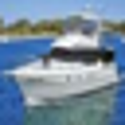

In [14]:
from PIL import Image
import requests

url = 'https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship1.png'
r = requests.get(url, stream=True)
input_image = Image.open(r.raw)
print("A sample image")
input_image.resize((125,125))

In order to run the search, first get the embedding vector for the input file, then use it to run a similarity search on the CassIO `VectorTable`:

Match 0: CIFAR10.1609 (label: ship, distance: 0.9867)
Match 1: CIFAR10.1601 (label: ship, distance: 0.9835)
Match 2: CIFAR10.1724 (label: ship, distance: 0.9831)
Match 3: CIFAR10.91 (label: airplane, distance: 0.9830)
Match 4: CIFAR10.1755 (label: ship, distance: 0.9822)


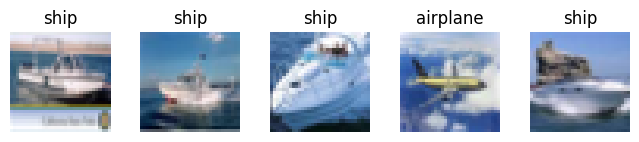

In [24]:
query_embedding = model(preprocess(input_image).unsqueeze(0).to(device)).tolist()[0]

matches = v_table.search(
        embedding_vector=query_embedding,
        top_k=5,
        metric="cos",
        metric_threshold=None,
    )

im_array_indices=[]
im_label_list=[]
# Show the top 5 matching results
for match_i, match in enumerate(matches):
      print(f"Match {match_i}: {match['document']} ", end="")
      print(f"(label: {match['metadata']['label']}, ", end="")
      print(f"distance: {match['distance']:.4f})")
      image_id=match['document'].split(".")
      im_array_indices.append(int(image_id[1]))
      im_label_list.append(match['metadata']['label'])

def display_top_5_matches(matches, im_array_indices, im_label_list):
    ### plot matching results
    fig = plt.figure(figsize=(8, 8))
    grid = ImageGrid(
          fig,
          111,
          nrows_ncols=(1, 5),
          axes_pad=0.3)

    for ax,im_array_index,im_label in zip(grid,im_array_indices,im_label_list):
        ax.imshow(selected_img_array[im_array_index])
        ax.set_title(im_label)
        ax.axis("off")

display_top_5_matches(matches, im_array_indices, im_label_list)

## Experiment with your own image file

In this section, you can supply any image file of your own to have a bit of fun.

While you're at it, do a bit of refactoring of the image processing steps:

In [25]:
def upload_image(filepath):
    loaded_image = Image.open(filepath)
    loaded_image=loaded_image.resize((80,80))
    return loaded_image

def image_similarity_search(supplied_image, top_k=5):
    # get the embeddings for the image from the model
    supplied_image_embedding = model(preprocess(supplied_image).unsqueeze(0).to(device)).tolist()[0]
    print((supplied_image_embedding))
    matches = v_table.search(
        embedding_vector=supplied_image_embedding,
        top_k=top_k,
        metric="cos",
        metric_threshold=None,
    )
    return matches

Now try providing an image file of yours (skip this part if you want):

Please provide the full path to the image file:  /home/USER/personal/Datastax/resources/generic/brain.png


Your query image:


ValueError: Could not save to JPEG for display

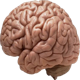

Similar images:


RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

In [26]:
if IS_COLAB:
    print("Please upload an image file from your computer:")
    uploaded = files.upload()
    img_file_title = list(uploaded.keys())[0]
    img_filepath = os.path.join(os.getcwd(), img_file_title)
else:
    img_filepath = input("Please provide the full path to the image file: ")

supplied_image= upload_image(img_filepath)
print("Your query image:")
display(supplied_image)
print("Similar images:")
upload_array_indices=[]
upload_label_list=[]
for match_i, match  in enumerate(image_similarity_search(supplied_image, top_k=3)):
      # Show the top 5 matching results
      print(f"Match {match_i}: {match['document']} ", end="")
      print(f"(label: {match['metadata']['label']}, ", end="")
      print(f"distance: {match['distance']:.4f})")
      image_id=match['document'].split(".")
      upload_array_indices.append(int(image_id[1]))
      upload_label_list.append(match['metadata']['label'])
display_top_5_matches(matches, upload_array_indices, upload_label_list)


## Image Similarity Web App

The following cells set up and launch a simple application, powered by [Gradio](https://www.gradio.app/) demonstrating the image similarity search seen so far.

In its essence, Gradio makes it easy to expose a graphical interface around the following function, built using the components seen earlier, that accepts a user-provided image as input and returns a number of results from the library, found by similarity.

In [27]:
NUM_RESULT_WIDGETS = 5

def gradio_upload_image(input_image):
    if input_image is not None:
        found_images = []
        for match_i, match  in enumerate(image_similarity_search(supplied_image, top_k=5)):
              # Show the top 5 matching results
              image_id=match['document'].split(".")
              found_images.append(selected_img_array[int(image_id[1])])
              plt.imshow(selected_img_array[int(image_id[1])])
    else:
        found_images = []
    # pad the result in any case to the number of displayed widgets
    return found_images+[None]*(NUM_RESULT_WIDGETS-len(found_images))

The next cell starts the Gradio app: click on the URL that will be displayed to open it.

Please keep in mind that:

- The cell will keep running as long as the UI is running. **Interrupt the notebook kernel to regain control** (e.g. to modify and re-launch, or execute other cells, etc).
- The cell output will give both a local URL to access the application, and an URL such as `https://<....>.gradio.live` to reach it from anywhere. **Use the latter link from Colab and when sharing with others**. _(The link will expire after a certain time.)_
- The UI will also be shown within the notebook below the cell.

In [ ]:
# Define the dimensions for output images
output_width = 300
output_height = 200

image_ui = gradio.Interface(
    fn=gradio_upload_image,
    inputs=gradio.inputs.Image(label="Your query image"),
    outputs=[
        gradio.components.Image(label=f"Search result #{output_i}",
        width=output_width, height=output_height)
        for output_i in range(NUM_RESULT_WIDGETS)
    ],
    title="Image Similarity Search with CassIO & Vector Database",
)
image_ui.launch(share=True, debug=True)

## What now?

This demo is hosted [here](https://cassio.org/frameworks/direct_cassio/image_similarity_vectors/) at cassio.org.

Discover the other ways you can integrate 
Cassandra/Astra DB with your ML/GenAI needs,
right **within [your favorite framework](https://cassio.org/frameworks/direct_cassio/about/)**.